In [17]:
zip_path = "/content/figshare.zip"   # change to your zip name
extract_dir = "/content/brain_tumor_mat"

import zipfile, os

os.makedirs(extract_dir, exist_ok=True)
with zipfile.ZipFile(zip_path, 'r') as z:
    z.extractall(extract_dir)

print("Extracted to:", extract_dir)


Extracted to: /content/brain_tumor_mat


In [18]:
!pip install h5py -q

import os
import glob
import h5py
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split


In [19]:
# Path to your Figshare .mat files
DATA_DIR = "/content/brain_tumor_mat/dataset/data"   # <- change if needed

IMG_SIZE = 256  # resize images to 256x256
BATCH_SIZE = 8
EPOCHS = 30


In [20]:
def load_mat_case(mat_path):
    """
    Loads one .mat file with structure:
       cjdata -> image, tumorMask, ...
    Returns: (image, mask) as numpy arrays.
    """
    with h5py.File(mat_path, "r") as f:
        cjdata = f["cjdata"]

        # h5py loads as (cols, rows), so we need transpose
        img = np.array(cjdata["image"]).T
        mask = np.array(cjdata["tumorMask"]).T

    return img, mask


def preprocess_image_and_mask(img, mask, target_size=(IMG_SIZE, IMG_SIZE)):
    """
    - Converts to float32
    - Normalizes image to [0,1]
    - Binarizes mask (0/1)
    - Resizes both to target size
    """
    img = img.astype("float32")
    mask = mask.astype("float32")

    # normalize image
    img = img / np.max(img + 1e-8)

    # ensure mask is 0/1
    mask = (mask > 0).astype("float32")

    # add channel dimension: (H,W) -> (H,W,1)
    img = np.expand_dims(img, axis=-1)
    mask = np.expand_dims(mask, axis=-1)

    # use TF to resize
    img = tf.image.resize(img, target_size, method="bilinear").numpy()
    mask = tf.image.resize(mask, target_size, method="nearest").numpy()

    return img, mask


def load_dataset_from_dir(data_dir):
    img_list = []
    mask_list = []

    mat_files = sorted(glob.glob(os.path.join(data_dir, "*.mat")))
    print(f"Found {len(mat_files)} .mat files")

    for path in mat_files:
        img, mask = load_mat_case(path)
        img, mask = preprocess_image_and_mask(img, mask)
        img_list.append(img)
        mask_list.append(mask)

    X = np.stack(img_list, axis=0)
    y = np.stack(mask_list, axis=0)
    print("X shape:", X.shape, "y shape:", y.shape)
    return X, y


X, y = load_dataset_from_dir(DATA_DIR)


Found 3064 .mat files
X shape: (3064, 256, 256, 1) y shape: (3064, 256, 256, 1)


In [22]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("Train:", X_train.shape, y_train.shape)
print("Val  :", X_val.shape, y_val.shape)


Train: (2451, 256, 256, 1) (2451, 256, 256, 1)
Val  : (613, 256, 256, 1) (613, 256, 256, 1)


In [23]:
def augment(image, mask):
    # random flip
    if tf.random.uniform(()) > 0.5:
        image = tf.image.flip_left_right(image)
        mask = tf.image.flip_left_right(mask)
    if tf.random.uniform(()) > 0.5:
        image = tf.image.flip_up_down(image)
        mask = tf.image.flip_up_down(mask)
    return image, mask


def make_dataset(images, masks, batch_size, training=True):
    ds = tf.data.Dataset.from_tensor_slices((images, masks))
    if training:
        ds = ds.shuffle(buffer_size=len(images))
        ds = ds.map(
            lambda x, y: augment(x, y),
            num_parallel_calls=tf.data.AUTOTUNE
        )
    ds = ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return ds


train_ds = make_dataset(X_train, y_train, BATCH_SIZE, training=True)
val_ds   = make_dataset(X_val,   y_val,   BATCH_SIZE, training=False)


In [24]:
def conv_block(x, filters):
    x = layers.Conv2D(filters, 3, padding="same", kernel_initializer="he_normal")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(filters, 3, padding="same", kernel_initializer="he_normal")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    return x


In [25]:
def attention_gate(x, g, inter_channels):
    """
    x: skip connection (encoder)
    g: gating signal (decoder)
    inter_channels: intermediate filters
    """
    theta_x = layers.Conv2D(inter_channels, 1, padding="same")(x)
    phi_g   = layers.Conv2D(inter_channels, 1, padding="same")(g)

    add = layers.Add()([theta_x, phi_g])
    act = layers.Activation("relu")(add)
    psi = layers.Conv2D(1, 1, padding="same")(act)
    psi = layers.Activation("sigmoid")(psi)

    # Multiply attention coefficients
    attn = layers.Multiply()([x, psi])
    return attn


In [26]:
def upsample_block(x, skip, filters):
    """
    x: input from previous decoder level
    skip: encoder skip connection to be filtered by attention
    """
    up = layers.UpSampling2D((2, 2), interpolation="bilinear")(x)
    attn = attention_gate(skip, up, inter_channels=filters // 2)
    concat = layers.Concatenate()([up, attn])
    out = conv_block(concat, filters)
    return out


In [27]:
def build_attention_unet(input_shape=(IMG_SIZE, IMG_SIZE, 1)):
    inputs = keras.Input(shape=input_shape)

    # ----- Encoder -----
    c1 = conv_block(inputs, 64)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = conv_block(p1, 128)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = conv_block(p2, 256)
    p3 = layers.MaxPooling2D((2, 2))(c3)

    c4 = conv_block(p3, 512)
    p4 = layers.MaxPooling2D((2, 2))(c4)

    # ----- Bottleneck -----
    c5 = conv_block(p4, 1024)

    # ----- Decoder (with Attention) -----
    u6 = upsample_block(c5, c4, 512)
    u7 = upsample_block(u6, c3, 256)
    u8 = upsample_block(u7, c2, 128)
    u9 = upsample_block(u8, c1, 64)

    # ----- Output -----
    outputs = layers.Conv2D(1, 1, activation="sigmoid")(u9)

    model = keras.Model(inputs, outputs, name="Attention_UNet")
    return model


model = build_attention_unet()
model.summary()


Model: "Attention_UNet"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_19 (Conv2D)  │ (None, 256, 256,  │        640 │ input_layer_1[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        256 │ conv2d_19[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_18       │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_20 (Conv2D)  │ (None, 256, 256,  │     36,928 │ activation_18[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        256 │ conv2d_20[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_19       │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 128, 128,  │          0 │ activation_19[0]… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_21 (Conv2D)  │ (None, 128, 128,  │     73,856 │ max_pooling2d_4[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        512 │ conv2d_21[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_20       │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_22 (Conv2D)  │ (None, 128, 128,  │    147,584 │ activation_20[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        512 │ conv2d_22[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_21       │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 64, 64,    │          0 │ activation_21[0]… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_23 (Conv2D)  │ (None, 64, 64,    │    295,168 │ max_pooling2d_5[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │      1,024 │ conv2d_23[0][0] 

 Total params: 31,925,029 (121.78 MB)

 Trainable params: 31,913,253 (121.74 MB)

 Non-trainable params: 11,776 (46.00 KB)

In [28]:
def dice_coef(y_true, y_pred, smooth=1e-6):
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (
        tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth
    )


def iou_coef(y_true, y_pred, smooth=1e-6):
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    union = tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) - intersection
    return (intersection + smooth) / (union + smooth)


def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)


In [29]:
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    loss=dice_loss,  # you can also use binary_crossentropy or combo
    metrics=["binary_crossentropy", dice_coef, iou_coef]
)


In [30]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        "attention_unet_best.keras", save_best_only=True, monitor="val_dice_coef", mode="max"
    ),
    keras.callbacks.EarlyStopping(
        monitor="val_dice_coef", patience=10, mode="max", restore_best_weights=True
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_dice_coef", factor=0.5, patience=5, mode="max", min_lr=1e-6
    ),
]

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=callbacks
)


Epoch 1/30
307/307 ━━━━━━━━━━━━━━━━━━━━ 360s 900ms/step - binary_crossentropy: 0.7227 - dice_coef: 0.1364 - iou_coef: 0.0751 - loss: 0.8636 - val_binary_crossentropy: 1.3293 - val_dice_coef: 0.1649 - val_iou_coef: 0.0907 - val_loss: 0.8350 - learning_rate: 1.0000e-04
Epoch 2/30
307/307 ━━━━━━━━━━━━━━━━━━━━ 209s 682ms/step - binary_crossentropy: 0.2148 - dice_coef: 0.3464 - iou_coef: 0.2131 - loss: 0.6536 - val_binary_crossentropy: 0.2103 - val_dice_coef: 0.4762 - val_iou_coef: 0.3167 - val_loss: 0.5237 - learning_rate: 1.0000e-04
Epoch 3/30
307/307 ━━━━━━━━━━━━━━━━━━━━ 209s 681ms/step - binary_crossentropy: 0.1449 - dice_coef: 0.4801 - iou_coef: 0.3226 - loss: 0.5199 - val_binary_crossentropy: 0.0657 - val_dice_coef: 0.5810 - val_iou_coef: 0.4142 - val_loss: 0.4188 - learning_rate: 1.0000e-04
Epoch 4/30
307/307 ━━━━━━━━━━━━━━━━━━━━ 209s 681ms/step - binary_crossentropy: 0.1050 - dice_coef: 0.5867 - iou_coef: 0.4215 - loss: 0.4133 - val_binary_crossentropy: 0.0713 - val_dice_coef: 0.655

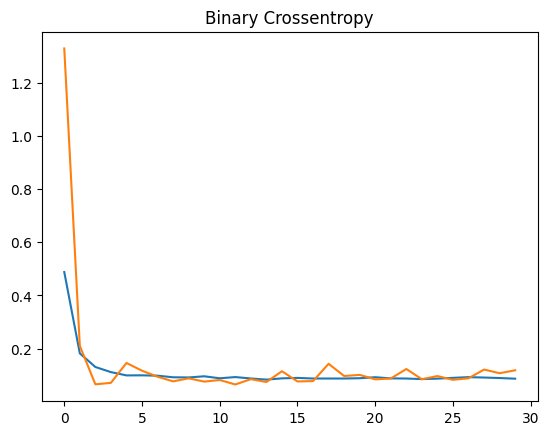

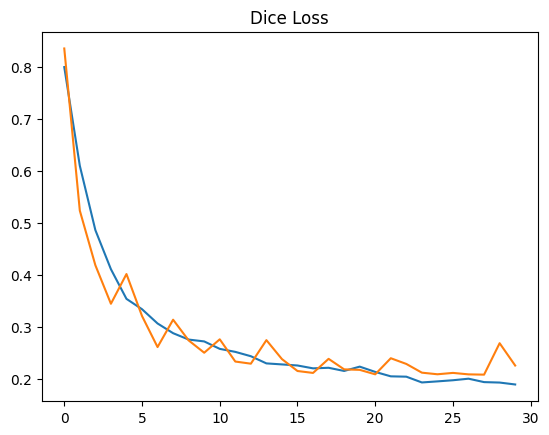

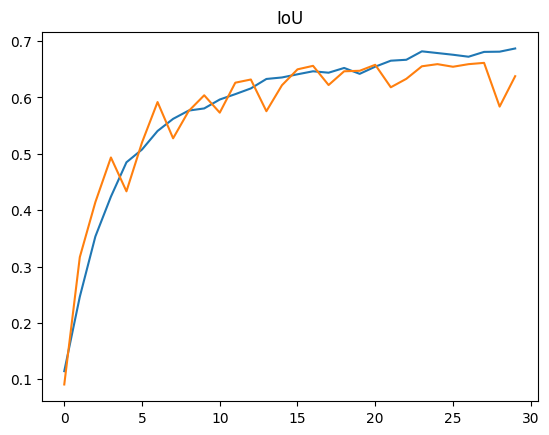

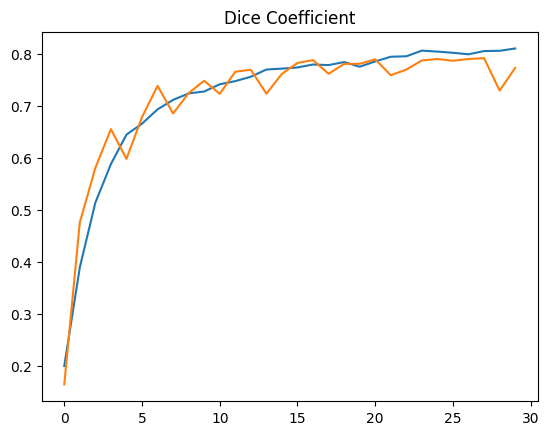

In [32]:
# Save BCE
plt.figure()
plt.plot(hist["binary_crossentropy"])
plt.plot(hist["val_binary_crossentropy"])
plt.title("Binary Crossentropy")
plt.savefig("bce_plot.png", dpi=300)

# Save Dice Loss
plt.figure()
plt.plot(hist["loss"])
plt.plot(hist["val_loss"])
plt.title("Dice Loss")
plt.savefig("dice_loss_plot.png", dpi=300)

# Save IoU
plt.figure()
plt.plot(hist["iou_coef"])
plt.plot(hist["val_iou_coef"])
plt.title("IoU")
plt.savefig("iou_plot.png", dpi=300)

# Save Dice Coefficient
plt.figure()
plt.plot(hist["dice_coef"])
plt.plot(hist["val_dice_coef"])
plt.title("Dice Coefficient")
plt.savefig("dice_coeff_plot.png", dpi=300)


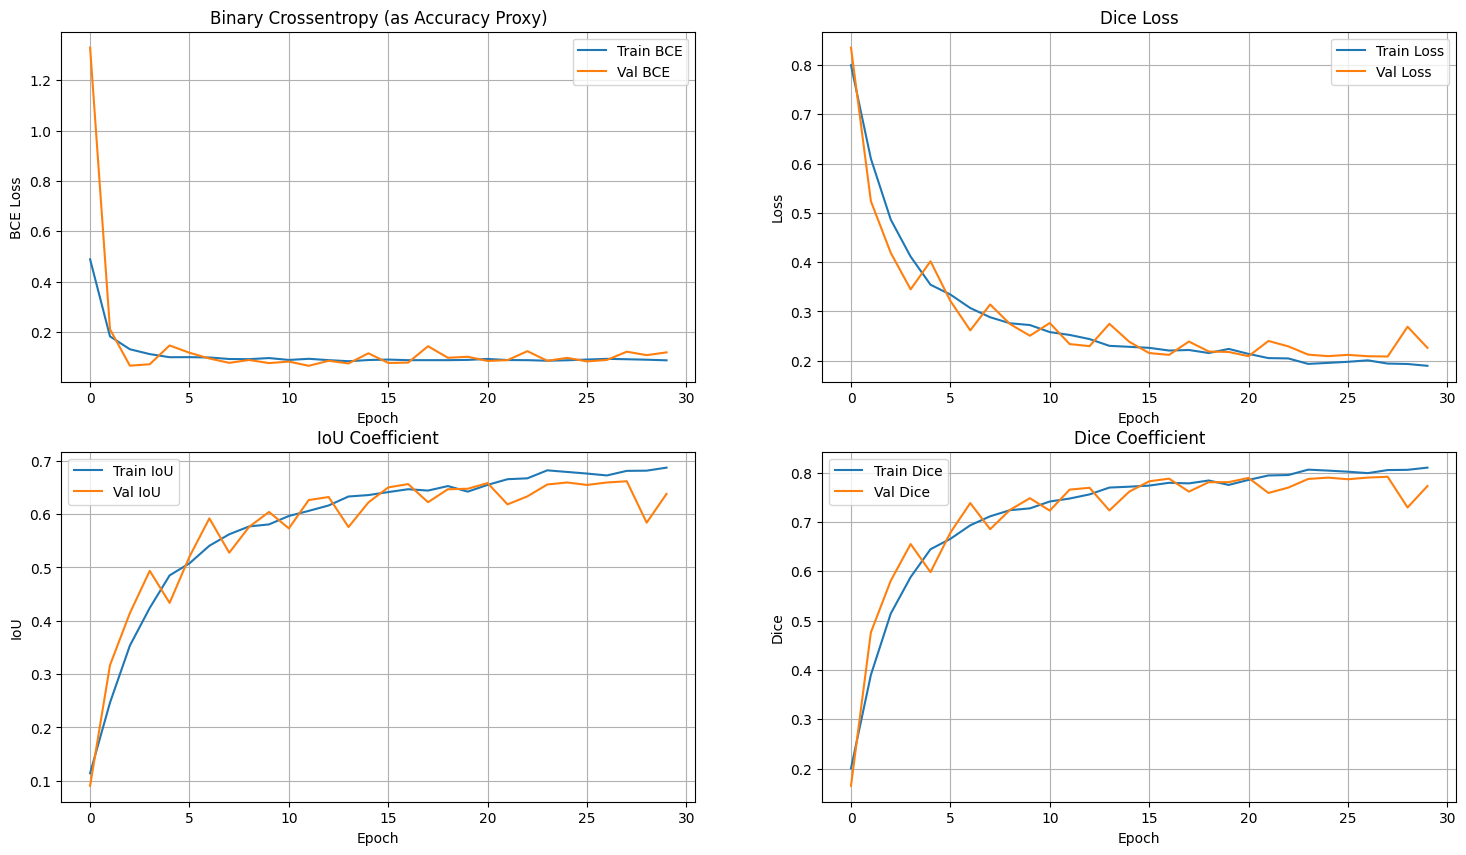

In [33]:
import matplotlib.pyplot as plt

hist = history.history

plt.figure(figsize=(18, 10))

# ------------------ ACCURACY / BCE ------------------
plt.subplot(2, 2, 1)
plt.plot(hist["binary_crossentropy"], label="Train BCE")
plt.plot(hist["val_binary_crossentropy"], label="Val BCE")
plt.title("Binary Crossentropy (as Accuracy Proxy)")
plt.xlabel("Epoch")
plt.ylabel("BCE Loss")
plt.legend()
plt.grid()

# ------------------ DICE LOSS ------------------
plt.subplot(2, 2, 2)
plt.plot(hist["loss"], label="Train Loss")
plt.plot(hist["val_loss"], label="Val Loss")
plt.title("Dice Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid()

# ------------------ IOU ------------------
plt.subplot(2, 2, 3)
plt.plot(hist["iou_coef"], label="Train IoU")
plt.plot(hist["val_iou_coef"], label="Val IoU")
plt.title("IoU Coefficient")
plt.xlabel("Epoch")
plt.ylabel("IoU")
plt.legend()
plt.grid()

# ------------------ DICE ------------------
plt.subplot(2, 2, 4)
plt.plot(hist["dice_coef"], label="Train Dice")
plt.plot(hist["val_dice_coef"], label="Val Dice")
plt.title("Dice Coefficient")
plt.xlabel("Epoch")
plt.ylabel("Dice")
plt.legend()
plt.grid()

# ----- SAVE THE FULL PLOT -----
plt.savefig("attention_unet_training_plots.png", dpi=300, bbox_inches='tight')

plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step


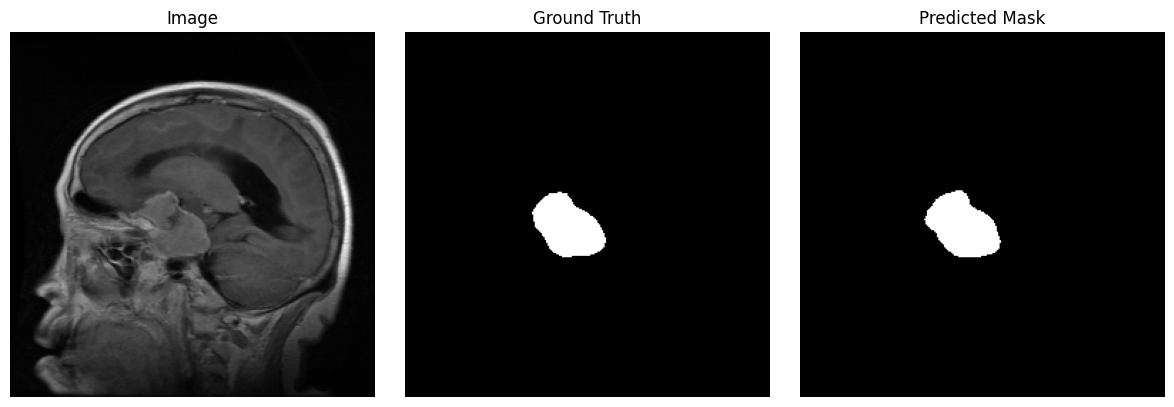

Saved: predictions/sample_380.png


In [34]:
import matplotlib.pyplot as plt
import numpy as np
import random
import os

# Directory to save predictions
os.makedirs("predictions", exist_ok=True)

def predict_and_show(index=None):
    # Choose random index if none
    if index is None:
        index = random.randint(0, len(X_val)-1)

    img = X_val[index]
    mask_true = y_val[index]

    # prediction
    pred = model.predict(img[np.newaxis, ...])[0]
    pred_bin = (pred > 0.5).astype("float32")

    # ---- Plot ----
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.title("Image")
    plt.imshow(img[..., 0], cmap="gray")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.title("Ground Truth")
    plt.imshow(mask_true[..., 0], cmap="gray")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.title("Predicted Mask")
    plt.imshow(pred_bin[..., 0], cmap="gray")
    plt.axis("off")

    plt.tight_layout()

    # Save to folder
    save_path = f"predictions/sample_{index}.png"
    plt.savefig(save_path, dpi=300, bbox_inches='tight')

    plt.show()

    print(f"Saved: {save_path}")

# Run once
predict_and_show()
